Veri yükleniyor...
Kayıt yükleniyor: 100/100
Inception1D modeli eğitiliyor...
Epoch 20/20, Train Loss: 0.0596, Test Loss: 0.2167

Değerlendirme metrikleri:


c:\Users\pasa-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\pasa-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\pasa-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\pasa-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\pasa-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_cl


XResNet1D modeli eğitiliyor...
Epoch 20/20, Train Loss: 0.0009, Test Loss: 0.5248

Değerlendirme metrikleri:


c:\Users\pasa-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\pasa-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\pasa-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\pasa-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\pasa-\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_cl


Model Karşılaştırması:
         model  accuracy  precision    recall     f1  auc_mean  train_loss  \
0  Inception1D      0.96   0.777778  1.000000  0.875       NaN    0.059556   
1    XResNet1D      0.94   0.750000  0.857143  0.800       NaN    0.000929   

   test_loss  
0   0.216724  
1   0.524801  


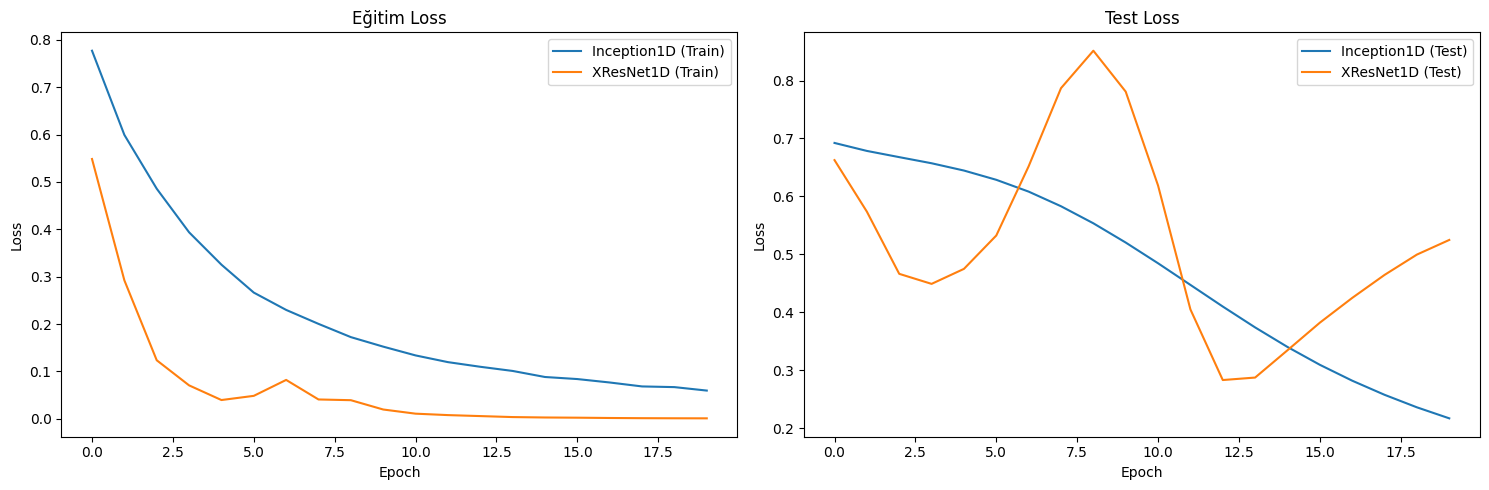

In [10]:
# notebooks/07_ptbxl_model_comparison.ipynb

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import StandardScaler

# 1. Model Mimarileri
class Inception1DBlock(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super().__init__()
        
        self.branch1 = nn.Conv1d(in_channels, out_1x1, kernel_size=1)
        
        self.branch2 = nn.Sequential(
            nn.Conv1d(in_channels, red_3x3, kernel_size=1),
            nn.BatchNorm1d(red_3x3),
            nn.ReLU(),
            nn.Conv1d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )
        
        self.branch3 = nn.Sequential(
            nn.Conv1d(in_channels, red_5x5, kernel_size=1),
            nn.BatchNorm1d(red_5x5),
            nn.ReLU(),
            nn.Conv1d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_channels, out_pool, kernel_size=1)
        )
        
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], 1)

class Inception1D(nn.Module):
    def __init__(self, n_leads=12, n_classes=5):
        super().__init__()
        
        self.pre_layers = nn.Sequential(
            nn.Conv1d(n_leads, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        self.inception_blocks = nn.Sequential(
            Inception1DBlock(64, 64, 96, 128, 16, 32, 32),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
            
            Inception1DBlock(256, 128, 128, 192, 32, 96, 64),
            nn.BatchNorm1d(480),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(480, n_classes)
        
    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception_blocks(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class ResBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
            
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class XResNet1D(nn.Module):
    def __init__(self, n_leads=12, n_classes=5):
        super().__init__()
        
        self.in_channels = 64
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(n_leads, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        # XResNet-101 yapısı
        self.layer1 = self.make_layer(64, 3)
        self.layer2 = self.make_layer(128, 4, stride=2)
        self.layer3 = self.make_layer(256, 23, stride=2)
        self.layer4 = self.make_layer(512, 3, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, n_classes)
        
    def make_layer(self, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResBlock1D(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 2. Veri yükleme ve ön işleme
def load_data(n_samples=100):
    data_path = Path("d:/ecg/data/raw/ptbxl")
    df = pd.read_csv(data_path / "ptbxl_database.csv")
    df = df.head(n_samples)
    
    waveforms = []
    labels = []
    diagnostic_classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
    
    for idx, row in df.iterrows():
        print(f"\rKayıt yükleniyor: {idx+1}/{n_samples}", end="")
        
        # EKG sinyalini yükle
        record_path = data_path / row['filename_hr'].replace('.hea', '')
        record = wfdb.rdrecord(str(record_path))
        waveform = record.p_signal
        
        # Normalize et
        scaler = StandardScaler()
        waveform = scaler.fit_transform(waveform)
        waveforms.append(waveform.T)  # (leads, time_steps)
        
        # Etiketleri hazırla
        label = np.zeros(len(diagnostic_classes))
        scp_codes = eval(row['scp_codes'])
        for diagnosis in scp_codes:
            if diagnosis in diagnostic_classes:
                label[diagnostic_classes.index(diagnosis)] = 1
        labels.append(label)
    
    return np.array(waveforms), np.array(labels)

# 3. Model eğitimi ve değerlendirme
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Eğitim
    n_epochs = 20
    train_losses = []
    test_losses = []
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        X_batch = torch.FloatTensor(X_train).to(device)
        y_batch = torch.FloatTensor(y_train).to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Testing
        model.eval()
        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(X_test).to(device)
            y_test_tensor = torch.FloatTensor(y_test).to(device)
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_losses.append(test_loss.item())
        
        print(f"\rEpoch {epoch+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}", end="")
    
    print("\n\nDeğerlendirme metrikleri:")
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        predictions = torch.sigmoid(model(X_test_tensor)).cpu().numpy()
        
        # Metrikler
        auc_scores = []
        for i in range(5):
            try:
                auc = roc_auc_score(y_test[:, i], predictions[:, i])
                auc_scores.append(auc)
            except:
                auc_scores.append(0)
        
        predictions_binary = (predictions > 0.5).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions_binary, average='weighted')
        accuracy = accuracy_score(y_test.flatten(), predictions_binary.flatten())
        
        metrics = {
            'model': model_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc_mean': np.mean(auc_scores),
            'train_loss': train_losses[-1],
            'test_loss': test_losses[-1]
        }
        
        return metrics, train_losses, test_losses

# 4. Ana test kodu
print("Veri yükleniyor...")
X, y = load_data(n_samples=100)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelleri test et
models = {
    'Inception1D': Inception1D(),
    'XResNet1D': XResNet1D()
}

results = []
loss_curves = {}

for name, model in models.items():
    print(f"\n{name} modeli eğitiliyor...")
    metrics, train_losses, test_losses = train_and_evaluate(model, X_train, y_train, X_test, y_test, name)
    results.append(metrics)
    loss_curves[name] = {'train': train_losses, 'test': test_losses}

# 5. Sonuçları görselleştir
# Metrikler tablosu
df_results = pd.DataFrame(results)
print("\nModel Karşılaştırması:")
print(df_results)

# Loss eğrileri
plt.figure(figsize=(15, 5))
for name in models.keys():
    plt.subplot(121)
    plt.plot(loss_curves[name]['train'], label=f'{name} (Train)')
    plt.title('Eğitim Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(loss_curves[name]['test'], label=f'{name} (Test)')
    plt.title('Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()